In [1]:
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

def add_text(ax, xoffset, yoffset, letter, size=12, **kwargs):
    ax.text(xoffset, yoffset, letter, transform=ax.transAxes,
            size=size, **kwargs)

figpath='figs/black_scholes/'


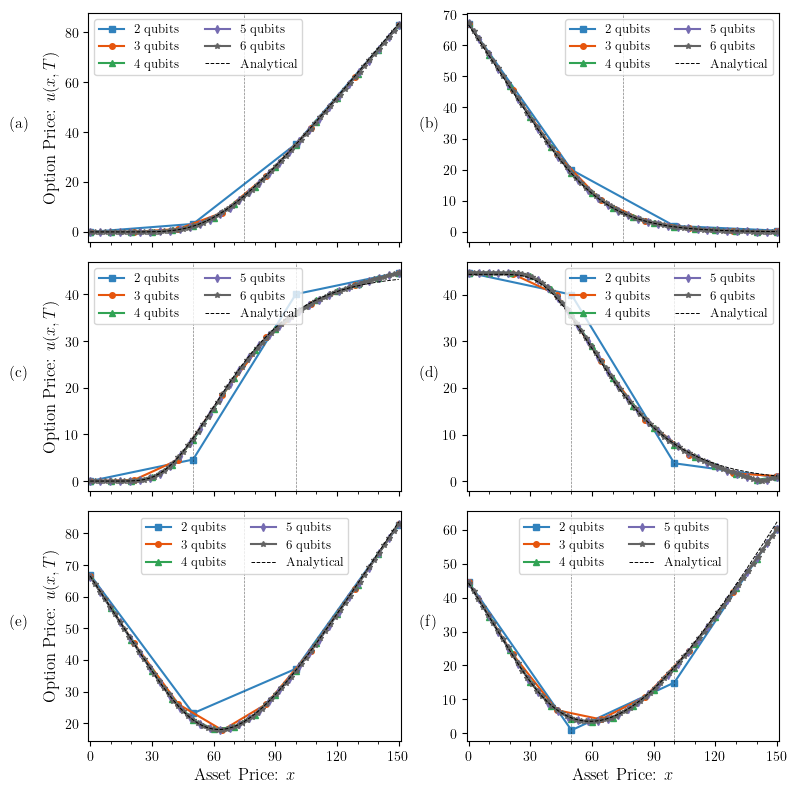

In [8]:

# styles = ['--', 'solid']
colors = list(map(plt.cm.tab20c, range(20)))
def get_color(n,Di):
    return colors[(n-2)*4 + ( o_index:=((n+1)//2 - Di - 1) )]
markers = 'so^d*'
styles = ['solid', 'dashed', 'dashdot']

h = []

fig = plt.figure(figsize=(8,8))
axs = fig.subplots(3,2,sharex=True)

legend_loc = ['upper left', 'upper right',
              'upper left', 'upper right',
              'upper center', 'upper center',
              ]

data_path = 'data/black_scholes/'
figname = 'solutions'
for oi, option_type in enumerate(options:=['call','put','BULL','BEAR','STRADDLE','STRANGLE']):
    ax = axs.flatten()[oi]
    # ax2 = ax1.twinx()
    for n in [2,3,4,5,6]:
        N = 2**n
        with h5py.File(f'{data_path}{option_type}_{n}_qubits.hdf5') as file:
            qnute_sols = file['rescaled_qnute_sols'][:]
            analytical_sols = file['analytical_sols'][:]
            Smin   = file.attrs['Smin']
            Smax   = file.attrs['Smax']
            T      = file.attrs['T']
            r      = file.attrs['r']
            q      = file.attrs['q']
            sigma  = file.attrs['sigma']
            strike = file.attrs['strike']
            Nt     = file.attrs['Nt']
        for Di,D in enumerate(np.arange(2,n+2,2)):
            # if option_type == 'call' and n == 4 and D == 2:
            #     continue
            # plt.plot(np.linspace(Smin,Smax,N), (sol:=qnute_sols[Di,-1,:])/np.linalg.norm(sol), label=f'{n=},{D=}')
            if D < n:
                continue
            l, = ax.plot(np.linspace(Smin,Smax,N), (sol:=qnute_sols[Di,-1,:]), 
                     label=f'{n} qubits', 
                    #  color=colors[(n-2)*4 + ( o_index:=((n+1)//2 - Di - 1) )],
                    color=get_color(n,Di),
                     marker=markers[n-2],
                     linestyle='solid',
                     ms=4,
                    #  alpha = (4-o_index)/4
                     )
            if option_type == options[0]:
                h.append(l)
    ax.plot(np.linspace(Smin,Smax,N),(sol:=analytical_sols[-1,:]),label='Analytical',color='k',linestyle='--', linewidth=0.7)
    for k in strike:
        ax.axvline(x=k, linewidth=0.5, linestyle='dashed', color='k',alpha=0.5)
    
    ax.legend(loc=legend_loc[oi], prop={'size':9}, ncols=2)
    add_text(ax, -0.25 + (oi%2)*0.1 ,0.5, f"({chr(ord('a')+oi)})", size=11)

for i in range(2):
    axs[-1][i].set_xlabel(r'Asset Price: $x$',fontsize=12)
for i in range(3):
    axs[i][0].set_ylabel(r'Option Price: $u(x,T)$',fontsize=12)
ax.set_xlim([Smin-1,Smax+1])
ax.set_xticks(np.arange(Smin,Smax+10,30))
ax.set_xticks(np.arange(Smin,Smax+10,10),minor=True)
# fig.legend(handles=h,loc='center right',ncols=1,prop={'size':9})
plt.tight_layout()

fig.savefig(figpath+figname+'.pdf', dpi=300, bbox_inches='tight')
fig.savefig(figpath+figname+'.png', dpi=300, bbox_inches='tight')
plt.show()

In [44]:
Smax

150

In [3]:
fids = np.zeros((6,5,3,Nt+1))
mses = np.zeros(fids.shape)
options = ['call','put','BULL','BEAR','STRADDLE','STRANGLE']
for oi,option_type in enumerate(options):
    # fig,axs = plt.subplots(1,2, figsize=(8,4))
    for n in [2,3,4,5,6]:
        N = 2**n
        with h5py.File(f'{data_path}{option_type}_{n}_qubits.hdf5') as file:
            qnute_sols = file['rescaled_qnute_sols'][:]
            analytical_sols = file['analytical_sols'][:]
            Smin   = file.attrs['Smin']
            Smax   = file.attrs['Smax']
            T      = file.attrs['T']
            r      = file.attrs['r']
            q      = file.attrs['q']
            sigma  = file.attrs['sigma']
            strike = file.attrs['strike']
            Nt     = file.attrs['Nt']
        dt = T/Nt
        fid = np.zeros((int(np.ceil(n/2)), Nt+1), np.float64)
        mse = np.zeros((int(np.ceil(n/2)), Nt+1), np.float64)
        for Di,D in enumerate(np.arange(2,n+2,2)):
            # if option_type == 'call' and n==4 and D==2:
            #     continue
            for ti in np.arange(Nt+1):
                t = ti*dt
                fid[Di,ti] = np.dot(qnute_sols[Di,ti,:],analytical_sols[ti,:])/(np.linalg.norm(qnute_sols[Di,ti,:]) * np.linalg.norm(analytical_sols[ti,:]))
                mse[Di,ti] = np.mean((qnute_sols[Di,ti,:] - analytical_sols[ti,:])**2)
            fids[oi,n-2,Di,:] = fid[Di,:]
            mses[oi,n-2,Di,:] = mse[Di,:]

    #         axs[0].plot(np.arange(0,Nt+1,skip:=50)*dt, 
    #                     fid[Di,::skip],
    #                     # np.log10(fid[Di,::skip]), 
    #                     label=f'{n=},{D=}', 
    #                     color=colors[(n-2)*4 + (o_index:=(n+1)//2 - Di - 1)],
    #                     marker=markers[o_index],
    #                     linestyle=styles[o_index],
    #                     ms=5,
    #                     alpha=(4-o_index)/4)
    #         axs[1].plot(np.arange(0,Nt+1,skip)*dt, np.log10(mse[Di,::skip]), 
    #                     # label=f'{n=},{D=}',
    #                     color=colors[(n-2)*4 + o_index],
    #                     marker=markers[o_index],
    #                     linestyle=styles[o_index],
    #                     ms=5,
    #                     alpha=(4-o_index)/4)

    # axs[0].set_title(f'{option_type.capitalize()} option fidelity' )
    # axs[1].set_title(f'{option_type.capitalize()} option $\\log$ MSE' )
    # axs[1].set_ylim([-5,11])
    # for ax in axs.flatten():
    #     # ax.legend()
    #     ax.set_xlabel('Time to Maturity ($\\tau$)')
    # # fig.legend(loc='lower center', ncols=4, bbox_to_anchor=(0.5,-0.25))
    # fig.legend(loc='center right', ncols=1, bbox_to_anchor=(1.08,0.5))
    # plt.show()
mean_fid = np.zeros((6,5,3))
std_fid = np.zeros(mean_fid.shape)
mean_mse = np.zeros(mean_fid.shape)
std_mse = np.zeros(mean_fid.shape)
keys = []

for oi,option in enumerate(options):
    for n in np.arange(2,6+1,1):
        for Di,D in enumerate(np.arange(2,n+2,2)):
            keys.append((option,n,D))
            mean_fid[oi,n-2,Di] = np.mean(fids[oi,n-2,Di,:])
            std_fid[oi,n-2,Di] = np.std(fids[oi,n-2,Di,:])
            mean_mse[oi,n-2,Di] = np.mean(mses[oi,n-2,Di,:])
            std_mse[oi,n-2,Di] = np.std(mses[oi,n-2,Di,:])
    #         print(f'{key=}, mean_fid={mean_fid[key]}')
    # print()

In [5]:
num_bars = 0
for n in range(2,6+1):
    # print(n, n//2 + n%2)
    num_bars += n//2 + n%2
print(num_bars)

11


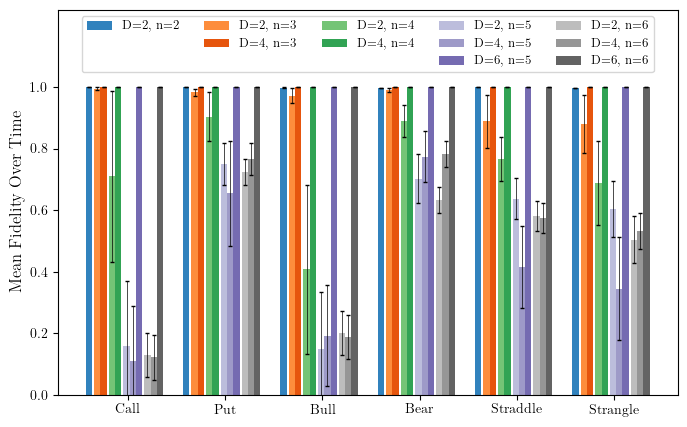

In [5]:
fig,ax = plt.subplots(figsize=(8,5))

num_bars = 11
bar_multiplier = 0
num_multiplier = 0
bar_width = 0.25  # the width of the bars
num_gap = 0.08
opt_gap = 0.8
opt_width = num_bars*bar_width + num_gap*4
x = np.arange(len(options))*(opt_width+opt_gap)  # first bar locations

h = []

for n in np.arange(2,6+1,1):
    for Di,D in enumerate(np.arange(2,n+2,2)):
        means = mean_fid[:,n-2,Di]
        b = ax.bar(x + bar_multiplier*bar_width + num_multiplier*num_gap, 
               means, bar_width, 
               label=f'{D=}, {n=}',
               color=colors[(n-2)*4 + ( o_index:=((n+1)//2 - Di - 1) )])
        ax.errorbar(x + bar_multiplier*bar_width + num_multiplier*num_gap,
                    means, yerr=std_fid[:,n-2,Di],
                    fmt='none',
                    # color=colors[(n-2)*4 + ( o_index:=((n+1)//2 - Di - 1) )]
                    color='k',linewidth=0.5,capsize=1.5
                    )
        h.append(b)
        bar_multiplier += 1
    for j in range(Di+1,3):
        b, = ax.plot(np.NaN, np.NaN, '-', color='none', label=' ')
        h.append(b)
    num_multiplier += 1

ax.legend(handles=h,loc='upper center',ncols=5, prop={'size':9})
ax.set_ylim([0,1.25])
ax.set_yticks(np.arange(0,1.0+(skip:=0.2),skip))
ax.set_xticks(x + opt_width/2, labels=[op.title() for op in options])
ax.set_ylabel('Mean Fidelity Over Time',fontsize=12)

# fig.suptitle('Mean Fidelity Over Time')
figpath = 'figs/black_scholes/'
figname = 'mean_fidelity'
fig.savefig(figpath+figname+'.pdf',dpi=300, bbox_inches='tight')
fig.savefig(figpath+figname+'.png',dpi=300, bbox_inches='tight')
plt.show()

C:\Users\CMP3KUMARS\AppData\Local\Temp\ipykernel_31416\2187313131.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.linspace(0,T,Nt+1),np.log10(mses[oi,n-2,Di,:]), label=f'{n=},{D=}', color=get_color(n,Di))


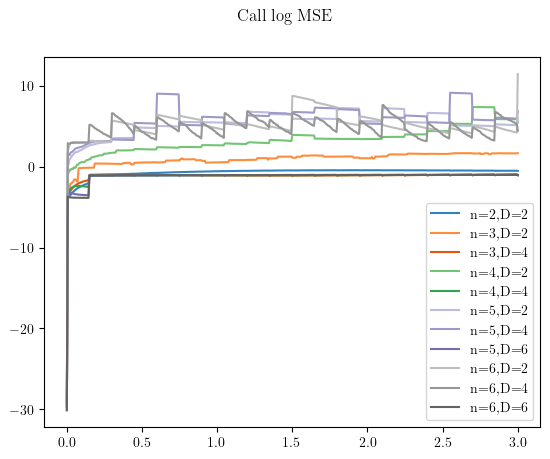

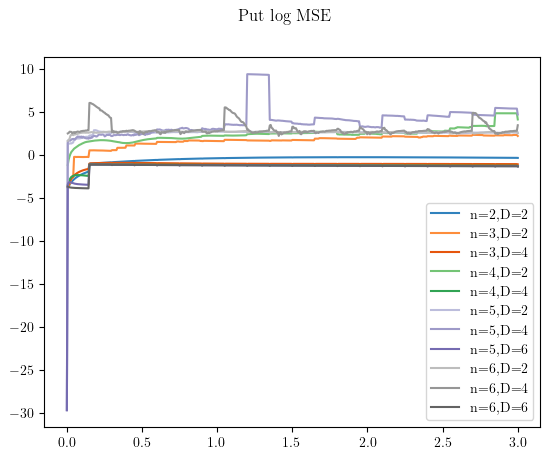

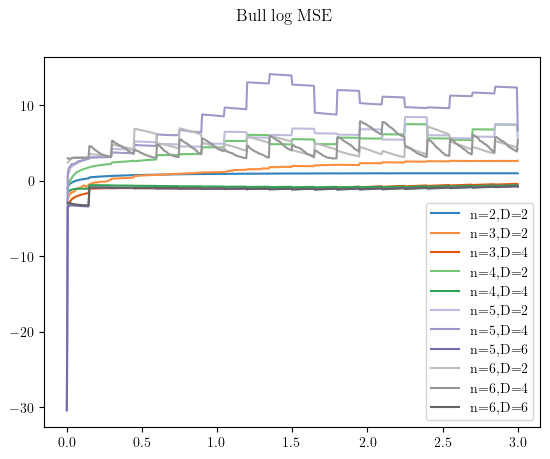

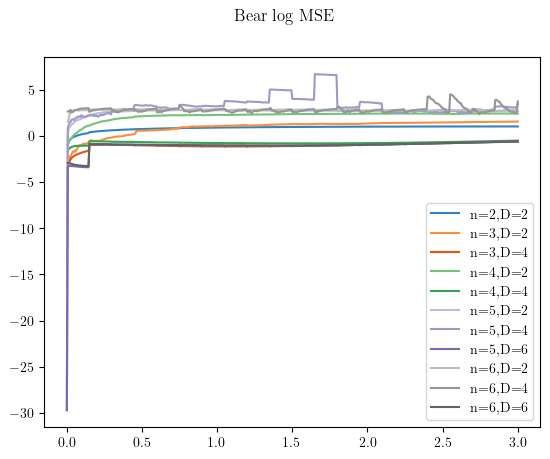

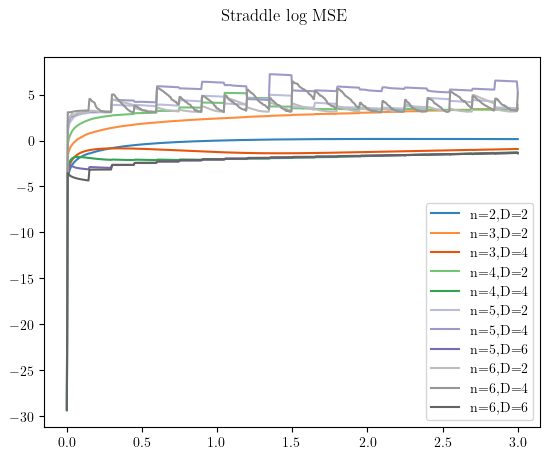

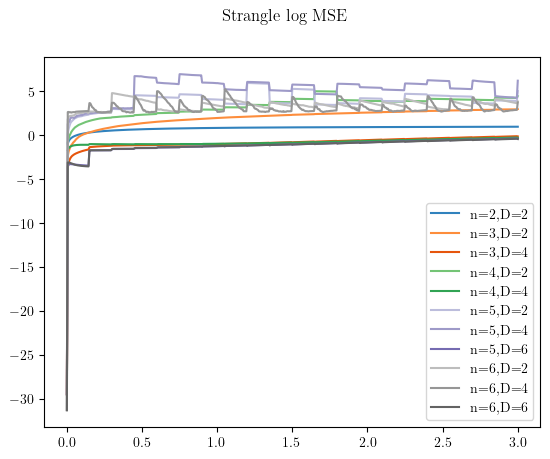

In [7]:
for oi,option in enumerate(options):
    for n in range(2,6+1):
        for Di,D in enumerate(np.arange(2,n+2,2)):
            # if mean_fid[oi,n-2,Di] < 0.8:
            #     print(option,n,D)
            #     continue
            plt.plot(np.linspace(0,T,Nt+1),np.log10(mses[oi,n-2,Di,:]), label=f'{n=},{D=}', color=get_color(n,Di))
            plt.suptitle(option.title()+' log MSE')
            plt.legend()
    plt.show()

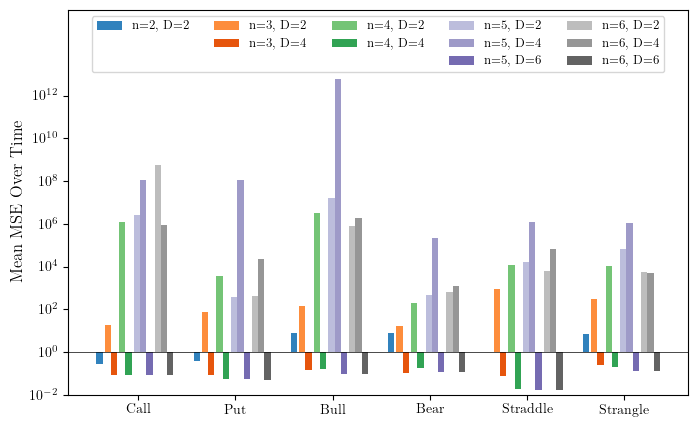

In [22]:
fig,ax = plt.subplots(figsize=(8,5))

num_bars = 11
bar_multiplier = 0
num_multiplier = 0
bar_width = 0.25  # the width of the bars
num_gap = 0.08
opt_gap = 0.8
opt_width = num_bars*bar_width + num_gap*4
x = np.arange(len(options))*(opt_width+opt_gap)  # first bar locations

h = []

for n in np.arange(2,6+1,1):
    for Di,D in enumerate(np.arange(2,n+2,2)):
        means = mean_mse[:,n-2,Di]
        b = ax.bar(x + bar_multiplier*bar_width + num_multiplier*num_gap, 
               np.log10(means), bar_width, label=f'{n=}, {D=}',
               color=colors[(n-2)*4 + ( o_index:=((n+1)//2 - Di - 1) )])
        # ax.errorbar(x + bar_multiplier*bar_width + num_multiplier*num_gap,
        #             means, yerr=std_mse[:,n-2,Di],
        #             fmt='none',
        #             # color=colors[(n-2)*4 + ( o_index:=((n+1)//2 - Di - 1) )]
        #             color='k',linewidth=0.5,capsize=1.5
        #             )
        h.append(b)
        bar_multiplier += 1
    for j in range(Di+1,3):
        b, = ax.plot(np.NaN, np.NaN, '-', color='none', label=' ')
        h.append(b)
    num_multiplier += 1

ax.legend(handles=h,loc='upper center',ncols=5, prop={'size':9})
ax.set_ylim([0,16])
ax.set_yticks(y:=(np.arange(-2,13,skip:=2)), labels=[(r'$10^{'+f'{i}'+r'}$') for i in y])
ax.set_xticks(x + opt_width/2, labels=[op.title() for op in options])
ax.set_ylabel('Mean MSE Over Time',fontsize=12)

ax.axhline(y=0,color='k',linestyle='solid',linewidth=0.5)

# fig.suptitle('Mean Fidelity Over Time')
figpath = 'figs/black_scholes/'
figname = 'mean_mse'
# fig.savefig(figpath+figname+'.pdf',dpi=300)
# fig.savefig(figpath+figname+'.png',dpi=300)
plt.show()